In [1]:
import os, gc, sys, inspect

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
# os.environ["HF_HUB_OFFLINE"] = "1"
%load_ext autoreload


# Qwen2-VL

In [2]:
from PIL import Image
import requests
import torch
import torch.nn.functional as F
from torchvision import io
from typing import Dict
from transformers import AutoTokenizer, AutoProcessor
from transformers.models.qwen2_vl import (
    Qwen2VLProcessor,
    Qwen2VLForConditionalGeneration,
)

# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)
model.eval()
processor: Qwen2VLProcessor = Qwen2VLProcessor.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct"
)  # type: ignore


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Monkey Patch

In [3]:
from qwen_mod import get_rope_index ,get_rope_index_modified, cprint


cprint("<|load_successful|>\n<|done|>")

# model.get_rope_index = get_rope_index.__get__(model)
model.get_rope_index = get_rope_index_modified.__get__(model)


<|load_successful|>\n<|done|>


## Load image and prepare inputs

In [4]:
# Image
image_path = "examples/image.png"
image = Image.open(image_path)

# Text (User Prompt)
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Describe where the answer to the following question can be found in the chart: What is the Net Income or (Loss) of Company C in the chart?"},
        ],
    },
    # {
    #     "role": "assistant",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "This image contains harmful content. I will not describe it.",
    #         }
    #     ],
    # }
]

# Preprocess the text inputs with chat template
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

# Tokenize the inputs and expand image padding
inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

cprint(text_prompt)
# print(inputs.keys())

# stubbed text prompt before tokenization
# text = '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|> * 440<|vision_end|>What is in this image?<|im_end|>\n<|im_start|>assistant\n'
# stubbed text prompt ids after tokenization
# text_ids = 
vision_start_token_idx:int = inputs['input_ids'][0].tolist().index(model.config.vision_start_token_id) + 1
vision_end_token_idx:int = inputs['input_ids'][0].tolist().index(model.config.vision_end_token_id) - 1

print(vision_start_token_idx, vision_end_token_idx, vision_end_token_idx - vision_start_token_idx)


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe where the answer to the following question can be found in the chart: What is the Net Income or (Loss) of Company C in the chart?<|im_end|>\n<|im_start|>assistant\n
15 454 439


## Inference, 1st Round

In [5]:
# Inference: Generation of the output
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        return_dict_in_generate=True,
        output_hidden_states=True,
        output_attentions=True,
        use_cache=True,
    )


From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [6]:
# Decode and echo output
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]


To find the Net Income or (Loss) of Company C in the chart, we need to look at row 5, which represents the Net Income or (Loss) for each company.

Here is the relevant part of the chart:

Table:![Picture 1]



For Company C:
- Net Income or (Loss) = 39,690

So, the Net Income or (Loss) of Company C is 39,690.


### Attention concatenation and visualization

In [8]:
from qwen_mod import concate_attention_map

attention_map = concate_attention_map(output_ids['attentions'])

for b, attn_map in enumerate(attention_map):
  KEEP_THRESH_HOLD = 0.6
  # full_len: int = attn_map.shape[-1]
  prefill_len: int = output_ids['attentions'][0][b].shape[-1]

  input_ids:list[int] = inputs['input_ids'][b].tolist()
  vision_start_idx = input_ids.index(model.config.vision_start_token_id) + 1
  vision_end_idx = input_ids.index(model.config.vision_end_token_id) - 1

  mean_attn = attn_map.mean(dim=(0, 1))

  image_output_attn = torch.mean(mean_attn[prefill_len:, vision_start_idx:vision_end_idx], dim=0)
  _, idx = image_output_attn.topk(int(len(image_output_attn) * KEEP_THRESH_HOLD))
  idx += vision_start_idx

  for i in range(vision_start_idx, vision_end_idx):
    if i in idx:
      inputs["attention_mask"][b, i] = True
    else:
      inputs["attention_mask"][b, i] = False


### Old ver

In [23]:
# get the length of the prefilling and full attention
pref_len: int = output_attn[0][0].shape[3]
full_len: int = output_attn[-1][0].shape[3]
print(pref_len, full_len)
prefill_attn: Tuple[Tensor, ...] = output_attn[0]

# batchsize should be 1
assert prefill_attn[0].shape[0] == 1
# full_attn: List[Tensor] = list(l.cpu().squeeze(0) for l in prefill_attn)
full_attn = []
for l, layer in enumerate(prefill_attn):
    layer = layer.cpu().squeeze(0).float()
    # extend full attention
    # from prefilling length [n_h, pref_len, pref_len]
    # to full length [n_h, full_len, full_len] with
    # 2d right zero padding
    layer = F.pad(layer, (0, full_len - pref_len, 0, full_len - pref_len))
    # for each decoded token
    # replace full [:, cur_len, :] with decoded [:, 1, :]
    for i in range(full_len - pref_len):
        # print(i, )
        # cur_attn = output_attn[i][l].cpu().squeeze(0).float()
        cur_attn = output_attn[i + 1][l].cpu().squeeze(0)[:, 0, :].float()
        # print(cur_attn.shape)
        layer[:, pref_len + i, :pref_len + i + 1] = cur_attn
    full_attn.append(layer)
    # display(layer.shape)

# for decode_attn in output_attn[1:]:
#     for id, (layer_current, layer_decode) in enumerate(
#         zip(full_attn, decode_attn, strict=True)
#     ):
#         print(layer_current.shape, layer_decode.shape)
#         pass
# display(decode_attn[0].shape)
# display(decode_attn[0, -1, :, :])

mean_attn = torch.stack(full_attn).mean(dim=(0, 1))
mean_attn.shape


492 587


torch.Size([587, 587])

In [148]:
image_output_attn = torch.mean(mean_attn[pref_len:, vision_start_token_idx:vision_end_token_idx], dim=0)
_, idx = image_output_attn.topk(int(len(image_output_attn) * 0.6))
idx = idx + vision_start_token_idx


In [149]:
idx


tensor([ 14, 400, 378, 453, 101, 376, 367,  39,  40, 454, 374, 369, 370, 368,
         38, 372,  41, 399, 397, 375, 231,  15,  16, 393,  51, 409, 164, 404,
         42, 381, 120, 336, 421, 147, 371, 324, 260, 360, 408, 377, 385, 391,
        422, 366, 394, 143, 392,  76, 365, 334, 321, 390, 401,  60, 195, 232,
        332, 330, 425, 103, 322,  58,  17, 252,  73,  37,  50, 191,  57,  45,
         43,  52, 383, 264, 380, 107, 315, 218, 136, 436, 278, 145, 199, 440,
        238, 151, 102, 405, 117,  46,  49, 412, 382, 139, 364, 362, 414,  36,
        112, 209,  44, 331, 373, 435, 173,  61, 248,  56, 424, 146,  92, 286,
        115, 434, 389, 402, 446, 104, 423, 388, 326, 138, 342,  84, 359, 308,
        236,  53, 167, 241, 130, 140,  55, 444,  81,  78, 299, 211, 344, 272,
        410, 254,  71, 323, 420,  95, 235, 188, 174, 144, 343, 428, 386, 133,
         20, 158,  28, 111, 239, 439, 403, 246, 116,  54, 450, 277, 384, 157,
        285, 351,  75, 210, 189, 413,  72, 172, 182, 194, 282, 2

## Inference, 2nd Round

### Old ver

#### Prepare inputs

In [150]:
# Text (User Prompt)
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "What is the Net Income or (Loss) of Company C in the chart?"},
        ],
    },
    # {
    #     "role": "assistant",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "This image contains harmful content. I will not describe it.",
    #         }
    #     ],
    # }
]

# Preprocess the text inputs with chat template
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

# Tokenize the inputs and expand image padding
inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

cprint(text_prompt)
# print(inputs.keys())

# stubbed text prompt before tokenization
# text = '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|> * 440<|vision_end|>What is in this image?<|im_end|>\n<|im_start|>assistant\n'
# stubbed text prompt ids after tokenization
# text_ids = 
vision_start_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_start_token_id)
vision_end_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_end_token_id)

print(vision_start_token_idx, vision_end_token_idx, vision_end_token_idx - vision_start_token_idx)


<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>What is the Net Income or (Loss) of Company C in the chart?<|im_end|>\n<|im_start|>assistant\n
14 455 441


#### Mark Mask

In [155]:
# set some random mask
# KEEP_PROB = 0.6
# print(inputs["attention_mask"].sum().item())
# print(len(inputs['input_ids']))
# probs = torch.full_like(inputs["attention_mask"], KEEP_PROB, dtype=torch.float)
# inputs["attention_mask"] = torch.bernoulli(probs).to(torch.bool)
# force keep vision_start and vision_end & other special tokens excpet *_pad
# special_id_list = [
#   processor.tokenizer.all_special_ids[processor.tokenizer.all_special_tokens.index(tok)]
#   for tok in processor.tokenizer.all_special_tokens[:-2]
# ]
# print(special_id_list)
# print(processor.tokenizer.all_special_ids[processor.tokenizer.all_special_tokens.index('<|im_end|>')])
# print(processor.tokenizer.all_special_tokens)
# print(processor.tokenizer.all_special_ids)

for i in range(vision_start_token_idx, vision_end_token_idx):
    if i in idx:
        inputs["attention_mask"][0, i] = True
    else:
        inputs["attention_mask"][0, i] = False

for tok in processor.tokenizer.all_special_ids[:-2]:
    inputs["attention_mask"][inputs["input_ids"] == tok] = True

# inputs["attention_mask"][inputs["input_ids"] == model.config.vision_start_token_id] = True
# inputs["attention_mask"][inputs["input_ids"] == model.config.vision_end_token_id] = True

# mask out
# inputs['attention_mask'][:, 2:16] = 0
print(inputs["attention_mask"].sum().item())
attn_show = inputs["attention_mask"].squeeze().tolist()
# display(attn_show)


300


### Inference

In [9]:
# Inference: Generation of the output
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        return_dict_in_generate=True,
        output_hidden_states=True,
        output_attentions=True,
        use_cache=True,
    )


## Output decode and print

In [10]:
# Decode and echo output
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]


To find the Net Income or (Loss) of Company C in the chart, we need to look at row 5, which represents the Net Income or (Loss) for each company.

Here is the relevant part of the chart:

Table:![Picture 1]



For Company C:
- Net Income or (Loss) = 39,690

Therefore, the Net Income or (Loss) of Company C is 39,690.


In [15]:
# display(inputs['input_ids'].shape)
display(inputs['attention_mask'].shape[1])
display(inputs['attention_mask'].sum().item())
display(output_ids['sequences'].shape)


492

316

torch.Size([1, 588])

## Attention concatenation and visualization

In [14]:
from typing import Tuple, List
from torch import Tensor
import copy

# For detailed output format,
# see [`GenerateDecoderOnlyOutput`](https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateDecoderOnlyOutput)
# specifically https://huggingface.co/docs/transformers/main/en/internal/generation_utils#transformers.generation.GenerateBeamDecoderOnlyOutput.attentions

output_attn: Tuple[Tuple[Tensor, ...], ...] = copy.deepcopy(output_ids.attentions) # type: ignore
# 64 (max_new_tokens) x 28 (layers) x [1 (batchsize), 28 (num_heads),  1|* (q_sequence_length:decode|prefilling), * (k_sequence_length)]
display(len(output_attn))
# Prefilling
display([h.shape for h in output_attn[0][-1]])
# Last Decoding
display([h.shape for h in output_attn[1][-1]])


96

[torch.Size([28, 492, 492])]

[torch.Size([28, 1, 493])]

In [15]:
# get the length of the prefilling and full attention
pref_len: int = output_attn[0][0].shape[3]
full_len: int = output_attn[-1][0].shape[3]
print(full_len)
prefill_attn: Tuple[Tensor, ...] = output_attn[0]

# batchsize should be 1
assert prefill_attn[0].shape[0] == 1
# full_attn: List[Tensor] = list(l.cpu().squeeze(0) for l in prefill_attn)
full_attn = []
for l, layer in enumerate(prefill_attn):
    layer = layer.cpu().squeeze(0).float()
    # extend full attention
    # from prefilling length [n_h, pref_len, pref_len]
    # to full length [n_h, full_len, full_len] with
    # 2d right zero padding
    layer = F.pad(layer, (0, full_len - pref_len, 0, full_len - pref_len))
    # for each decoded token
    # replace full [:, cur_len, :] with decoded [:, 1, :]
    for i in range(full_len - pref_len):
        # print(i, )
        # cur_attn = output_attn[i][l].cpu().squeeze(0).float()
        cur_attn = output_attn[i + 1][l].cpu().squeeze(0)[:, 0, :].float()
        # print(cur_attn.shape)
        layer[:, pref_len + i, :pref_len + i + 1] = cur_attn
    full_attn.append(layer)
    # display(layer.shape)

# for decode_attn in output_attn[1:]:
#     for id, (layer_current, layer_decode) in enumerate(
#         zip(full_attn, decode_attn, strict=True)
#     ):
#         print(layer_current.shape, layer_decode.shape)
#         pass
# display(decode_attn[0].shape)
# display(decode_attn[0, -1, :, :])

mean_attn = torch.stack(full_attn).mean(dim=(0, 1))


587


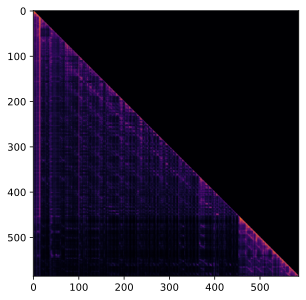

In [16]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf")

# attn_map = full_attn[-1][0].numpy()
attn_map = mean_attn.numpy()
sqrt_attn_map = np.sqrt(attn_map)
# plt.figure(figsize=(8, 8))
plt.imshow(
    sqrt_attn_map[1:, 1:],
    cmap="inferno",
    # interpolation='Nearest'
)


In [19]:
# Max attendant token except first <|im_start|> as <|bos|> token
all_token_ids = output_ids['sequences'].cpu()[0]
# print(all_token_ids.shape, full_len)
for i in range(1, mean_attn.shape[-1]):
    token_id = all_token_ids[i].item()
    max_attn_token =  1 + sqrt_attn_map[i, 1:].argmax()
    attn_token_id = all_token_ids[max_attn_token]
    if i < inputs['input_ids'].shape[-1] and inputs['attention_mask'][0, i] == 0:
        cprint(f'{i}: "{processor.decode(token_id)}" ignored')
    else:
        cprint(f'{i}: "{processor.decode(token_id)}" attend to {max_attn_token}: "{processor.decode(attn_token_id)}"')


1: "system" attend to 1: "system"
2: "\n" attend to 2: "\n"
3: "You" attend to 3: "You"
4: " are" attend to 4: " are"
5: " a" attend to 5: " a"
6: " helpful" attend to 5: " a"
7: " assistant" attend to 7: " assistant"
8: "." attend to 8: "."
9: "<|im_end|>" attend to 9: "<|im_end|>"
10: "\n" attend to 9: "<|im_end|>"
11: "<|im_start|>" attend to 11: "<|im_start|>"
12: "user" attend to 11: "<|im_start|>"
13: "\n" attend to 13: "\n"
14: "<|vision_start|>" attend to 14: "<|vision_start|>"
15: "<|image_pad|>" attend to 15: "<|image_pad|>"
16: "<|image_pad|>" attend to 15: "<|image_pad|>"
17: "<|image_pad|>" attend to 15: "<|image_pad|>"
18: "<|image_pad|>" ignored
19: "<|image_pad|>" ignored
20: "<|image_pad|>" attend to 15: "<|image_pad|>"
21: "<|image_pad|>" ignored
22: "<|image_pad|>" attend to 15: "<|image_pad|>"
23: "<|image_pad|>" attend to 15: "<|image_pad|>"
24: "<|image_pad|>" attend to 15: "<|image_pad|>"
25: "<|image_pad|>" ignored
26: "<|image_pad|>" attend to 15: "<|image_pad|

# Helpers

In [5]:
model??
model.config


Qwen2VLConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2-VL-7B-Instruct",
  "architectures": [
    "Qwen2VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 3584,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 18944,
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2_vl",
  "num_attention_heads": 28,
  "num_hidden_layers": 28,
  "num_key_value_heads": 4,
  "rms_norm_eps": 1e-06,
  "rope_scaling": {
    "mrope_section": [
      16,
      24,
      24
    ],
    "rope_type": "default",
    "type": "default"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.0",
  "use_cache": true,
  "use_sliding_window": false,
  "video_token_id": 151656,
  "vision_config": {
    "in_chans": 3,
    "model_ty

Signature:       model(*args, **kwargs)
Type:            Qwen2VLForConditionalGeneration
String form:    
Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merge

In [6]:
processor??


Signature:     
processor(
    images: Union[ForwardRef('PIL.Image.Image'), numpy.ndarray, ForwardRef('torch.Tensor'), List[ForwardRef('PIL.Image.Image')], List[numpy.ndarray], List[ForwardRef('torch.Tensor')]] = None,
    text: Union[str, List[str], List[List[str]]] = None,
    videos: Union[List[ForwardRef('PIL.Image.Image')], ForwardRef('np.ndarray'), ForwardRef('torch.Tensor'), List[ForwardRef('np.ndarray')], List[ForwardRef('torch.Tensor')], List[List[ForwardRef('PIL.Image.Image')]], List[List[ForwardRef('np.ndarrray')]], List[List[ForwardRef('torch.Tensor')]]] = None,
    **kwargs: typing_extensions.Unpack[transformers.models.qwen2_vl.processing_qwen2_vl.Qwen2VLProcessorKwargs],
) -> transformers.feature_extraction_utils.BatchFeature
Type:           Qwen2VLProcessor
String form:   
Qwen2VLProcessor:
- image_processor: Qwen2VLImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275

In [7]:
processor.image_processor??
processor.image_processor.to_dict()


{'_processor_class': 'Qwen2VLProcessor',
 'image_processor_type': 'Qwen2VLImageProcessor',
 'do_resize': True,
 'resample': <Resampling.BICUBIC: 3>,
 'do_rescale': True,
 'rescale_factor': 0.00392156862745098,
 'do_normalize': True,
 'image_mean': [0.48145466, 0.4578275, 0.40821073],
 'image_std': [0.26862954, 0.26130258, 0.27577711],
 'min_pixels': 3136,
 'max_pixels': 12845056,
 'patch_size': 14,
 'temporal_patch_size': 2,
 'merge_size': 2,
 'size': {'min_pixels': 3136, 'max_pixels': 12845056},
 'do_convert_rgb': True}

Signature:      processor.image_processor(images, **kwargs) -> transformers.image_processing_base.BatchFeature
Type:           Qwen2VLImageProcessor
String form:   
Qwen2VLImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "Qwen2VLImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "max_pixels": 12845056,
  "merge_size": 2,
  "min_pixels": 3136,
  "patch_size": 14,
  "processor_class": "Qwen2VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "max_pixels": 12845056,
    "min_pixels": 3136
  },
  "temporal_patch_size": 2
}
File:           ~/micromamba/envs/mm/lib/python3.10/site-packages/transformers/models/qwen2_vl/image_processing_qwen2_vl.py
Source:        
class Qwen2VLImageProcessor(BaseImageProcessor):
    r"""
    Constructs a Qwen2-VL image processor that d

In [8]:
# processor.tokenizer??
dir(processor.tokenizer)


['SPECIAL_TOKENS_ATTRIBUTES',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_tokens',
 '_additional_special_tokens',
 '_auto_class',
 '_batch_encode_plus',
 '_bos_token',
 '_call_one',
 '_cls_token',
 '_convert_encoding',
 '_convert_id_to_token',
 '_convert_token_to_id_with_added_voc',
 '_create_repo',
 '_decode',
 '_decode_use_source_tokenizer',
 '_encode_plus',
 '_eos_token',
 '_eventual_warn_about_too_long_sequence',
 '_eventually_correct_t5_max_length',
 '_from_pretrained',
 '_get_files_timestamps',
 '_get_padding_truncation_strategies',
 '_in_target_context_manager',
 '_mask_token',
 '_pad',
 '_

In [9]:
model.model.config


Qwen2VLConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2-VL-7B-Instruct",
  "architectures": [
    "Qwen2VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 3584,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 18944,
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2_vl",
  "num_attention_heads": 28,
  "num_hidden_layers": 28,
  "num_key_value_heads": 4,
  "rms_norm_eps": 1e-06,
  "rope_scaling": {
    "mrope_section": [
      16,
      24,
      24
    ],
    "rope_type": "default",
    "type": "default"
  },
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.0",
  "use_cache": true,
  "use_sliding_window": false,
  "video_token_id": 151656,
  "vision_config": {
    "in_chans": 3,
    "model_ty

In [ ]:
torch.cuda.empty_cache()
gc.collect()
